In [826]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from numpy import genfromtxt
from scipy import stats

In [827]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    # 아래꺼 np.c_만 하면 되는거 아닌가? reshape는 왜하지
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [828]:
def read_student_as_pandas():
    df = pd.read_csv('student-mat.csv', sep=';')
    return df

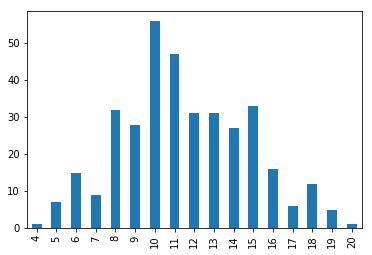

In [829]:
df = read_student_as_pandas()
df.tail()

# drop outlier
df.drop(df[df['G3'] == 0].index, inplace=True)
df['G3'].value_counts().sort_index().plot('bar')

In [830]:
# pandas categorical column to numeric
# https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
str_columns = df.select_dtypes(['object']).columns
for col in str_columns:
    df[col] = df[col].astype('category')

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
390,1,1,20,1,1,0,2,2,3,3,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,1,1,1,3,1,3,3,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,0,0,1,1,1,2,2,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,0,1,1,3,2,3,2,...,4,4,1,3,4,5,0,11,12,10
394,1,1,19,1,1,1,1,1,2,0,...,3,2,3,3,3,5,5,8,9,9


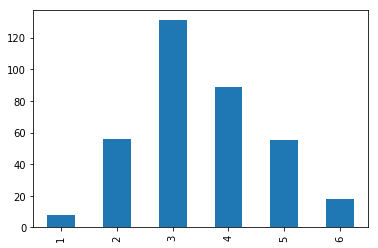

In [831]:
grade_cluster_size = 3
df['G3'] = df['G3'].apply(lambda x: x / grade_cluster_size)
df['G3'].unique()
df['G3'].value_counts().sort_index().plot('bar')

In [832]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1:].values
print stats.describe(features).variance
print features.shape, labels.shape

[  1.04097819e-01   2.50369811e-01   1.60848834e+00   1.71230290e-01
   2.10477449e-01   9.75828534e-02   1.19683379e+00   1.17552639e+00
   1.48391716e+00   7.35923583e-01   1.47452239e+00   2.82378120e-01
   4.70698392e-01   6.92049854e-01   4.51247915e-01   1.20778649e-01
   2.37796242e-01   2.50464231e-01   2.50684543e-01   1.59774022e-01
   3.77836528e-02   1.36452334e-01   2.15906587e-01   7.84502565e-01
   1.02333742e+00   1.18979952e+00   8.46190161e-01   1.67695842e+00
   1.96739370e+00   6.70371699e+01   1.05005193e+01   9.90479338e+00]
(357, 32) (357, 1)


In [833]:
normalized_features = feature_normalize(features)
print stats.describe(normalized_features).variance

[ 1.00280899  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899
  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899
  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899
  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899
  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899  1.00280899
  1.00280899  1.00280899]


In [834]:
feature_count = normalized_features.shape[1]
label_count = labels.shape[1]

print feature_count, label_count

rnd_indices = np.random.rand(len(features)) < 0.70

train_x = normalized_features[rnd_indices]
train_y = labels[rnd_indices]
test_x = normalized_features[~rnd_indices]
test_y = labels[~rnd_indices]

32 1


In [835]:
training_epochs = 2000
learning_rate = 0.01
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 7  # nb_classes = 21 / grade_cluster_size

# x는 float32 로 할 필요가 있나? normalized 되었기때문에 float32 써야함
X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

('one_hot', <tf.Tensor 'one_hot_53:0' shape=(?, 1, 7) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_178:0' shape=(?, 7) dtype=float32>)


In [836]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, w_h, w_h2, w_h3, w_4, w_o, p_keep_input, p_keep_hidden): # this network is the same as the previous one except with an extra hidden layer + dropout
    X = tf.nn.dropout(X, p_keep_input)
    print w_h.shape[1], type(w_h.shape[1])
    b = tf.Variable(tf.random_normal([32]))
    h = tf.nn.relu(tf.matmul(X, w_h) + b)
    
    h = tf.nn.dropout(h, p_keep_hidden)
    b2 = tf.Variable(tf.random_normal([32]))
    h2 = tf.nn.relu(tf.matmul(h, w_h2) + b2)

    h2 = tf.nn.dropout(h2, p_keep_hidden)
    b3 = tf.Variable(tf.random_normal([32]))
    h3 = tf.nn.relu(tf.matmul(h2, w_h3) + b3)
    
    h3 = tf.nn.dropout(h3, p_keep_hidden)
    b4 = tf.Variable(tf.random_normal([32]))
    h4 = tf.nn.sigmoid(tf.matmul(h3, w_h4) + b4)
    
    h4 = tf.nn.dropout(h4, p_keep_hidden)

    return tf.matmul(h4, w_o)

In [837]:
# w0, b0, h0 = get_class_logits()

w_h = init_weights([feature_count, feature_count])
w_h2 = init_weights([feature_count, feature_count])
w_h3 = init_weights([feature_count, feature_count])
w_h4 = init_weights([feature_count, feature_count])
w0 = init_weights([feature_count, nb_classes])

p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

h0 = model(X, w_h, w_h2, w_h3, w_h4, w0, p_keep_input, p_keep_hidden)

32 <class 'tensorflow.python.framework.tensor_shape.Dimension'>


In [838]:
# https://github.com/carpedm20/DCGAN-tensorflow/issues/99
# all_logits = tf.concat([h0, h1, h2], 1)

regularizers = tf.nn.l2_loss(w0)

# Cross entropy cost/loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))+ 1e-4*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [839]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [840]:
print train_x.shape, train_y.shape
print X.shape, Y.shape
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y, p_keep_input: 0.8, p_keep_hidden: 0.5})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y, p_keep_input: 0.8, p_keep_hidden: 0.5})
        cost_history = np.append(cost_history, acc)
        if step % 500 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x, 
                                                         p_keep_input: 1.0,
                                                         p_keep_hidden: 1.0}))

(253, 32) (253, 1)
(?, 32) (?, 1)
Step:     0	Loss: 1.857	Acc: 34.78%
Step:   500	Loss: 0.869	Acc: 62.85%
Step:  1000	Loss: 0.889	Acc: 66.01%
Step:  1500	Loss: 0.832	Acc: 64.82%
Step:  2000	Loss: 0.812	Acc: 62.45%
(104,)
('Test Accuracy:', 0.66346157)


(2002,)


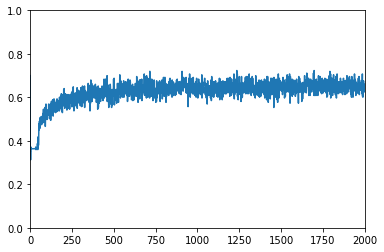

In [841]:
print cost_history.shape
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [842]:
sess.close()